## Table of Contents:
* [Import Packages](#first-bullet)
* [Word2Vec on ND DOT 511](#second-bullet)
* [Train Model and Build Vocbulary](#third-bullet)
* [Visualizing word relationships using TSNE](#fourth-bullet)
* [Classify News as Relevant or Irrelevant](#fifth-bullet)
* [Weather API Model](#sixth-bullet)
* [Getting coordinates for Relevant Articles](#seventh-bullet)
* [Mapping with Basemap (matplotlib) ](#eigth-bullet)

# Import Packages <a class="anchor" id="first-bullet"></a>

Here we import the pakages that will be used in our modeling.  If there are any issues loading in the NLP data from Spacy.  There is a link to a Github forum that addresses the issues.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

In [5]:
import en_core_web_sm
nlp = en_core_web_sm.load()
#https://github.com/explosion/spaCy/issues/1283

In [6]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag

In [7]:
import spacy
from spacy import displacy
from collections import Counter
import en_core_web_sm
nlp = en_core_web_sm.load()

In [20]:
import gensim

paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress


In [53]:
from gensim import corpora

In [ ]:
from nltk.corpus import stopwords
from nltk import download
from gensim import corpora

In [ ]:
import string
import re 

In [ ]:
from nltk.corpus import stopwords 

In [ ]:
from pprint import pprint  # pretty-printer
from collections import defaultdict

In [ ]:
import sklearn.manifold

In [ ]:
import gensim.downloader as api
from gensim.models import WordEmbeddingSimilarityIndex
from gensim.similarities import SparseTermSimilarityMatrix

In [ ]:
from geopy.geocoders import Nominatim
#https://github.com/geopy/geopy

In [ ]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt

# Word2Vec on ND DOT 511  <a class="anchor" id="second-bullet"></a>

Now, we will create a dataframe from the ND 511 data.  This set of data contains the post and headline of the road closures.  All of these alerts are addressing road closures.  We will compare these texts to the news and weather API articles to determine their similarity.  If the news and weather texts are similar to the ND511 alerts, then we will say that they are more likely to be addressing a road closure.

## Import  ND 511 data

In [21]:
#model = gensim.models.KeyedVectors.load_word2vec_format('./lexvec.enwiki+newscrawl.300d.W.pos.vectors.gz')

In [22]:
df_nd = pd.read_csv('./data/nd_511.csv')

In [23]:
df_nd.head()

,Unnamed: 0,alert_type,headline,url,post
0,2,Road Conditions,"Water receded on I-29, 20 miles north of Grand...",/dotnet/news/Public/View/8335,Water has receded on northbound I-29 approxima...
1,3,Road Conditions,ND Hwy 5 temporarily closed from I-29 to the R...,/dotnet/news/Public/View/8334,The North Dakota Department of Transportation ...
2,4,Road Conditions,Water on I-29 north of Grand Forks,/dotnet/news/Public/View/8333,There is water on the southbound lanes of I-29...
3,5,Road Conditions,Water on I-29 north of Grand Forks,/dotnet/news/Public/View/8332,There is water on the northbound lanes of I-29...
4,6,Road Conditions,Southbound on ramp on I-29 Exit 164 north of G...,/dotnet/news/Public/View/8331,The North Dakota Department of Transportation ...


## Remove named entities, to make it generic to MN

Using the locations that spaCy identified in the dataset, we will remove these from our texts so that they are more generic.  We don't want the location names in ND to be included in our model, as it may reward articles that mention North Dakota specific places, while we want to reward articles that are focusing on road closures.  We are also removing times and dates, as we don't want to reward articles for taking place in the same time frame as the ND 511 set.

In [24]:
locations = []
for i in df_nd['post']:
    doc = nlp(i)
    locations.append([(X.text, X.label_) for X in doc.ents])

In [25]:
locations[0]

[('approximately 20 miles', 'QUANTITY'),
 ('Grand Forks', 'FAC'),
 ('two', 'CARDINAL'),
 ('511', 'CARDINAL'),
 ('NDDOT', 'ORG')]

The output of our spaCy function is a list of tuples.  The first entry is the location or time, and the second is the named entity category.  We want to turn this into a list of only location and time names.

In [27]:
# make list of words to remove from corpus (all named entites, keeping in quantities)

locations_and_dates = []

for i in locations:
    for j in i:
        locations_and_dates.append(j[0])

Now, we want to remove all duplicate values in our list by turning them into a set.

In [28]:
gpes = set(locations_and_dates)

Finally, we want to remove a few items from our set of places and times.  These are terms that spaCy picked up, that are not specific times (eg. evening) or locations ('Snowplows).  These are words that should be considered by our models.

In [30]:
remove = ['Alert', 'Alert\r\n', 'Alert\xa0', 'Advisory','BLOCKED\xa0','Blizzard','Blizzard Warning','Commercial Motor Vehicle',
 'Commercial Motor Vehicles', 'Highway','LIFTED',
 'LIFTED  ','Motorists','No Travel Advised','No Travel Advised LIFTED','No Travel Advisory LIFTED','OPEN',
 'OPENED','Overnight','Pack','Road\r\n     Closed','Road Closed','Road Closures','Snowplows','The Travel Alert',
 'This Travel\r\nAlert','Travel\r\nAlerts','Travel Alert','Wind Chill Warning','Winter Storm Warning','daily',
 'early morning hours',
 'evening',
 'every day',
 'morning',]
for i in remove:
    gpes.remove(i)

We next need to begin processing our text strings for our Word2vec model.  We will first remove punctuation, as well as some strings that relate to the website names that appear in the texts.  These strings do not add any value to our data, and should be removed.

In [31]:
nd_list = df_nd["post"].values

In [33]:

removed_punct_nd = [''.join(c for c in s if c not in string.punctuation) for s in nd_list]

In [34]:

pattern = '[0-9]'
nc_remove_nums = [re.sub(pattern, '', i) for i in removed_punct_nd]

In [35]:
nc_remove_nums = [re.sub('\n', ' ', i) for i in nc_remove_nums]
nc_remove_nums = [re.sub('\xa0', ' ', i) for i in nc_remove_nums]
nc_remove_nums = [re.sub('blocked–', 'blocked', i) for i in nc_remove_nums]
nc_remove_nums = [re.sub('–', ' ', i) for i in nc_remove_nums]  
nc_remove_nums = [re.sub('wwwdotndgov', '', i) for i in nc_remove_nums]
nc_remove_nums = [re.sub('httpsndrepsonsegov', '', i) for i in nc_remove_nums]
nc_remove_nums = [re.sub('nddot', '', i) for i in nc_remove_nums] 
nc_remove_nums = [re.sub('httpstravelinfov', '', i) for i in nc_remove_nums]
nc_remove_nums = [re.sub("'s'", '', i) for i in nc_remove_nums]
nc_remove_nums = [re.sub('washburn', '', i) for i in nc_remove_nums]
nc_remove_nums = [re.sub('devil', '', i) for i in nc_remove_nums]

We will also need to remove punctuation from our list of named entities.  Then, we will remove all named entities from our list of ND 511 posts. This will leave us wil a list of strings.

In [36]:
removed_punct_gpes = [''.join(c for c in s if c not in string.punctuation) for s in gpes]

In [38]:
# remove gprs from list of lists
gpes
for j in removed_punct_gpes:
    nc_remove_nums = [re.sub(j, '', i) for i in nc_remove_nums]

In [40]:

stop_words = set(stopwords.words('english')) 

Now, we will turn our cleaned up list of ND 511 alerts into tokens that can be used by Wrod2vec.  We will remove common English stop words here as well.

In [41]:


# remove common words and tokenize
stoplist = stop_words#set('for a of the and to in with on'.split())
texts = [
    [word for word in nc_remove_nums.lower().split() if word not in stoplist]
    for nc_remove_nums in nc_remove_nums
]

# remove words that appear only once
frequency = defaultdict(int)
for text in texts:
    for token in text:
        frequency[token] += 1

texts = [
    [token for token in text if frequency[token] > 1]
    for text in texts
]

#pprint(texts)

# source - https://radimrehurek.com/gensim/tut1.html#corpus-formats
# https://github.com/kavgan/nlp-in-practice/blob/master/word2vec/Word2Vec.ipynb

# Train Model and Build Vocbulary  <a class="anchor" id="third-bullet"></a>

We are going to build a Word2vec model, using the texts from our ND 511 alerts as the training set.  The model will then be trained on this dataset.  Eventually, we will compare the news and weather alerts to this trained dataset.

In [42]:
# build vocabulary and train model
model = gensim.models.Word2Vec(
    texts,
    size=1500,
    window=10,
    min_count=2,
    workers=10)
model.train(texts, total_examples=len(texts), epochs=1) 

C:\Users\phill\Anaconda3\lib\site-packages\gensim\models\base_any2vec.py:743: UserWarning: C extension not loaded, training will be slow. Install a C compiler and reinstall gensim for fast training.
  "C extension not loaded, training will be slow. "


(11327, 21654)

Word2vec has a build into method to compare the cosine similarity of words to each other.  Using our trained ND 511 model, we can see how simlar a few sample words are.

In [43]:
model.most_similar('closed')

C:\Users\phill\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('threatening', 0.948833703994751),
 ('life', 0.9424770474433899),
 ('blocked', 0.9318242073059082),
 ('able', 0.9219838380813599),
 ('responders', 0.9213416576385498),
 ('emergency', 0.918928861618042),
 ('become', 0.9123826026916504),
 ('safely', 0.9121668934822083),
 ('drive', 0.9063537120819092),
 ('stranded', 0.9063376784324646)]

In [45]:
model.most_similar('blocked')

C:\Users\phill\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('life', 0.9841539859771729),
 ('closed', 0.9786981344223022),
 ('safely', 0.9665942192077637),
 ('threatening', 0.966561496257782),
 ('allowed', 0.9647164344787598),
 ('impassible', 0.9484252333641052),
 ('able', 0.9469383955001831),
 ('responders', 0.941205620765686),
 ('deteriorate', 0.9319429397583008),
 ('emergency', 0.9232921600341797)]

In [46]:
model.corpus_count

134

In [47]:
len(texts[0])

69

# Visualizing word relationships using TSNE   <a class="anchor" id="fourth-bullet"></a>

TSNE will allow us to visualize the relationships between the words in our ND-511 model on a 2D plane.  The model is a matrix containing the relationships betwwen the words, in many dimensions.  By reducing to only two dimensions, we will be able to plot the words on a 2d plane.

In [44]:

tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)

In [45]:
all_word_vectors_matrix = model.wv.syn0

C:\Users\phill\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  """Entry point for launching an IPython kernel.


In [46]:
all_word_vectors_matrix_2d = tsne.fit_transform(all_word_vectors_matrix)
# source for all below TSNE code is modified from: 
#https://github.com/llSourcell/word_vectors_game_of_thrones-LIVE/blob/master/Thrones2Vec.ipynb
# with updates from: https://groups.google.com/forum/#!topic/gensim/hlYgjqEVocw

In [47]:
points = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, all_word_vectors_matrix_2d[model.wv.vocab[word].index])
            for word in model.wv.vocab
        ]
    ],
    columns=["word", "x", "y"]
)

In [48]:
points.head(10)

,word,x,y
0,water,11.243468,15.394797
1,receded,-15.552171,-25.301725
2,northbound,12.710902,8.766642
3,approximately,-5.679542,-8.939366
4,north,15.880458,12.348894
5,forks,18.569265,11.960867
6,roadway,10.162446,14.844472
7,open,1.060422,-5.976877
8,lanes,15.323073,12.037295
9,traffic,7.616664,12.085118


In [49]:

sns.set_context("poster")

The scatter plot below shows all of the words in our ND-511 set, reduced to two dimensions and plotted on a scatter plot.

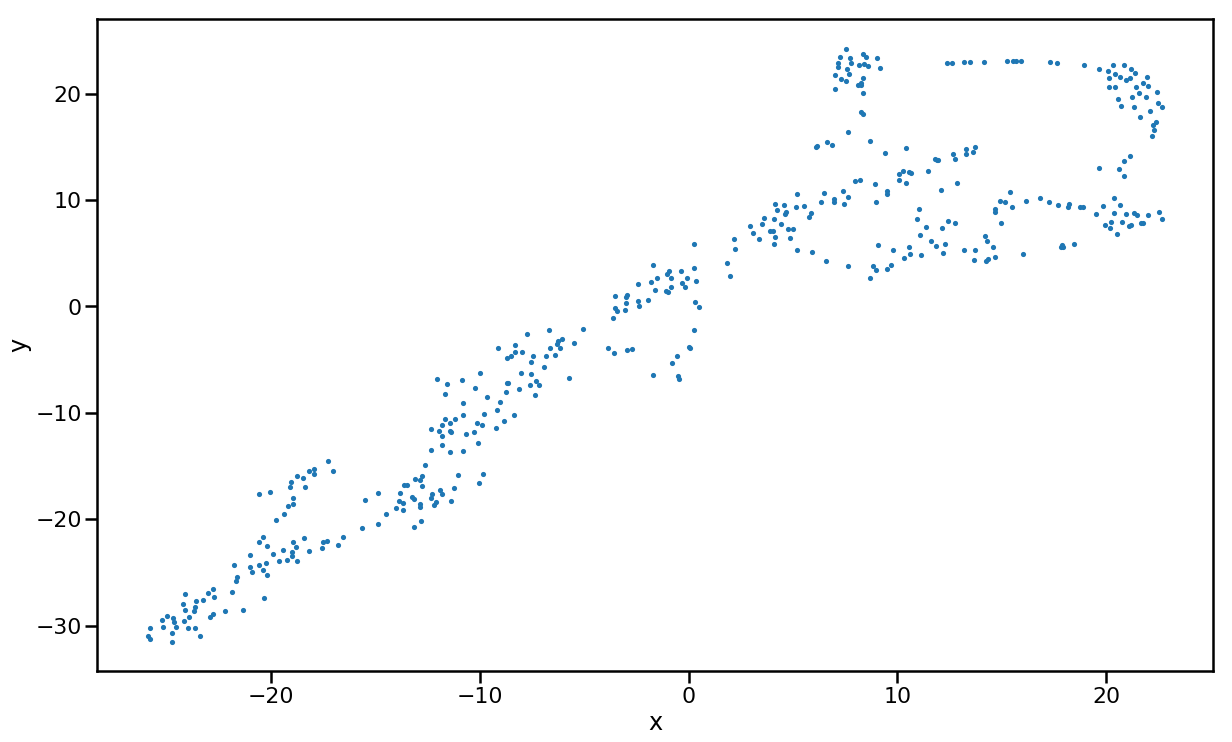

In [468]:
points.plot.scatter("x", "y", s=10, figsize=(20, 12))

Using the above graph, we can zoom in on a specific region, and add in the word as a lable.  THis will allow us to see which words are used together most often.  For example, in the second plot, we can see that "may" and "deteriorate" are neighbors.  This makes sense, since "may deteriorate" is a common phrase in the ND511 alerts.

In [359]:
def plot_region(x_bounds, y_bounds):
    slice = points[
        (x_bounds[0] <= points.x) &
        (points.x <= x_bounds[1]) & 
        (y_bounds[0] <= points.y) &
        (points.y <= y_bounds[1])
    ]
    
    ax = slice.plot.scatter('x', 'y', s=35, figsize=(10, 8))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)

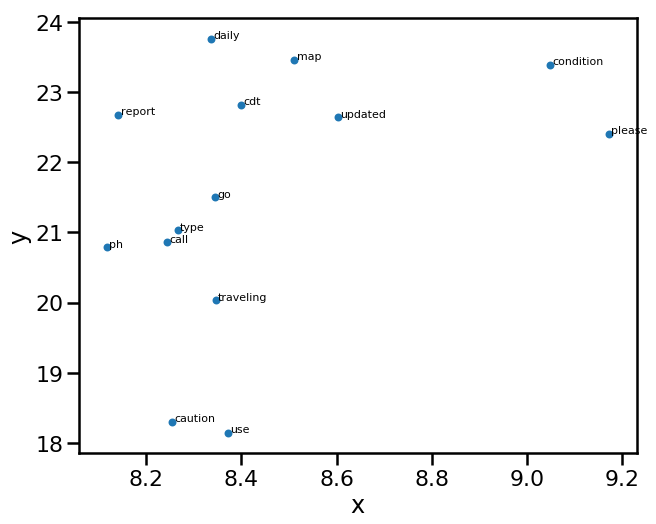

In [469]:
plot_region(x_bounds=(8, 10), y_bounds=(18, 25))
# play around with these numbers, it will change which points appear on the graph

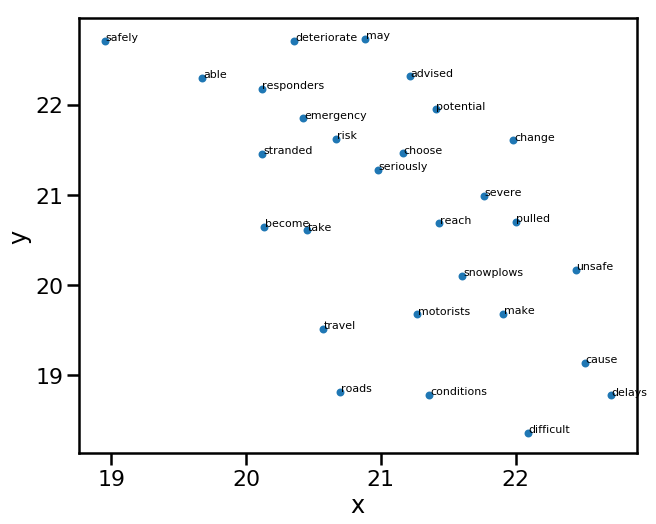

In [470]:
plot_region(x_bounds=(18, 23), y_bounds=(18, 23))

# Classify News as Relevant or Irrelevant   <a class="anchor" id="fifth-bullet"></a>

To compare our news API articles to the ND 511 alerts, we will first pull in the newsapi csv that was created in 1_apis_and_webscrapping.ipynb. 

Then, we will get it ready to be used word2vec model by tokenizing and removing stop words.

In [50]:
news_df_topics = pd.read_csv('./data/news_api_v2.csv')

In [51]:
news_list = news_df_topics['content'].values

In [52]:
# remove common words and tokenize
stoplist = stop_words#set('for a of the and to in with on'.split())
texts_news = [
    [word for word in news_list.lower().split() if word not in stoplist]
    for news_list in news_list
]

# remove words that appear only once
frequency = defaultdict(int)
for text in texts_news:
    for token in text:
        frequency[token] += 1

texts_news = [
    [token for token in text if frequency[token] > 1]
    for text in texts_news
]


In [55]:
list_of_words = []
for i in texts:
    for j in i:
        list_of_words.append(j)

In [56]:
list_of_words_news = []
for i in texts_news:
    for j in i:
        list_of_words_news.append(j)

Add in the tokenized news API text and North Dakota 511 data.  ND 511 will be what we are comparing the news articles to.
If the cosine similarity is high between the article and the 511 alerts (on average), we will consider the news article road
closure related.

In [57]:
combine_list = []
for i in (list_of_words, list_of_words_news):
    combine_list.append(i)

In [58]:
dictionary = corpora.Dictionary(combine_list)

In [59]:


w2v_model = api.load("glove-wiki-gigaword-50")

To see how relevant to road closures each of the news articles are, we will be comparing our vectorized articles to the vectorized ND 511 alerts.  We will be using the soft cosine measure.  This metric measures the similarity of documents by modeling synonymy.  So, if two sentences use a synonym for a word (eg "road closed" instead of "street blocked"), they will still score highly on the similarity value.

Our model will loop through each of the articles in the New API set, comparing them to each of the articles in the ND 511 set.  Once we have a soft cosine measure for each of the ND511 alerts for a given article, an average will be taken.  This average will serve as our measure of how related to road closures a given article is.

In [60]:
# gather similarities for each news article, compared to the nd 511 alerts
#get all sims for each article, then get the average
# source for idea: https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/soft_cosine_tutorial.ipynb
# add'l ideas here https://stackoverflow.com/questions/45876711/gensim-word2vec-wmd-similarity-dictionary
all_sims = []

similarity_index = WordEmbeddingSimilarityIndex(w2v_model)
similarity_matrix = SparseTermSimilarityMatrix(similarity_index, dictionary)

for idx, i in enumerate(texts_news):
    print(idx, 'article_num')
    sims = []
    sentance_news =  dictionary.doc2bow(i)
    for ind, j in enumerate(texts):
        #print(ind, 'iteration_num')
        sentence_nd =  dictionary.doc2bow(j)
        similarity = similarity_matrix.inner_product(sentance_news, sentence_nd, normalized=True)
        sims.append(similarity)
    all_sims.append(sims)

0 article_num
1 article_num
2 article_num
3 article_num
4 article_num
5 article_num
6 article_num
7 article_num
8 article_num
9 article_num
10 article_num
11 article_num
12 article_num
13 article_num
14 article_num
15 article_num
16 article_num
17 article_num
18 article_num
19 article_num
20 article_num
21 article_num
22 article_num
23 article_num
24 article_num
25 article_num
26 article_num
27 article_num
28 article_num
29 article_num
30 article_num
31 article_num
32 article_num
33 article_num
34 article_num
35 article_num
36 article_num
37 article_num
38 article_num
39 article_num
40 article_num
41 article_num
42 article_num
43 article_num
44 article_num
45 article_num
46 article_num
47 article_num
48 article_num
49 article_num
50 article_num
51 article_num
52 article_num
53 article_num
54 article_num
55 article_num
56 article_num
57 article_num
58 article_num
59 article_num
60 article_num
61 article_num
62 article_num
63 article_num
64 article_num
65 article_num
66 article_num
67 ar

1028 article_num
1029 article_num
1030 article_num
1031 article_num
1032 article_num
1033 article_num
1034 article_num
1035 article_num
1036 article_num
1037 article_num
1038 article_num
1039 article_num
1040 article_num
1041 article_num
1042 article_num
1043 article_num
1044 article_num
1045 article_num
1046 article_num
1047 article_num
1048 article_num
1049 article_num
1050 article_num
1051 article_num
1052 article_num
1053 article_num
1054 article_num
1055 article_num
1056 article_num
1057 article_num
1058 article_num
1059 article_num
1060 article_num
1061 article_num
1062 article_num
1063 article_num
1064 article_num
1065 article_num
1066 article_num
1067 article_num
1068 article_num
1069 article_num
1070 article_num
1071 article_num
1072 article_num
1073 article_num
1074 article_num
1075 article_num
1076 article_num
1077 article_num
1078 article_num
1079 article_num
1080 article_num
1081 article_num
1082 article_num
1083 article_num
1084 article_num
1085 article_num
1086 article_n

Calculate the average score for each article.  This will give us one number to compare the articles to eachother on.

In [61]:
def avg_function(lst): 
    return sum(lst) / len(lst) 

In [62]:
avgs = []

for i in all_sims:
    avg = avg_function(i)
    avgs.append(avg)

In [63]:
len(all_sims)

1381

In [64]:
len(avgs)

1381

In [65]:
news_df_topics['avg_cosine'] = avgs

Now that we have appended our avg. soft cosine values to each of the new articles, we can visually evaluate the model.  Because we are working on an unsupervised data set (we are not given a y value), we will have to evaluate our model by visually inspecing the data.

In [66]:
news_df_topics.head()

,Unnamed: 0,publishedAt,content,url,locations_and_times,avg_cosine
0,0,2019-04-15T16:41:00Z,The 2019 BMW M850i convertible (starting at $1...,https://www.engadget.com/2019/04/15/2019-bmw-m...,"[('2019', 'DATE')]",0.226761
1,1,2019-04-09T14:00:00Z,Running may be one of the simplest fitness act...,https://vitals.lifehacker.com/how-to-avoid-inj...,[],0.311644
2,2,2019-04-15T21:25:23Z,Volvo is taking technology that allowed some o...,http://techcrunch.com/2019/04/15/volvo-cars-in...,"[('Monday', 'DATE')]",0.390492
3,3,2019-03-30T04:01:00Z,"From the top of the mound, I cant see much. So...",https://www.wired.com/story/jeep-gladiator-pic...,"[('the past few days', 'DATE')]",0.160964
4,5,2019-03-28T15:03:00Z,"The Evoque (starting at $42,650) is the baby o...",https://www.engadget.com/2019/03/28/land-rover...,[],0.129242


Below are the twn articles with the highest average cosine values.  Note that because we pulled in data using multiple keywords, articles were pulled in more than once in some cases.  We will need to remove these.

In [67]:
news_df_topics.sort_values(by='avg_cosine', ascending=False).head()

,Unnamed: 0,publishedAt,content,url,locations_and_times,avg_cosine
92,111,2019-04-06T03:30:00Z,BC \r\nDriveBC has issued a number of travel ...,https://www.castanet.net/news/BC/253354/Forest...,[],0.573658
344,373,2019-04-06T03:30:00Z,BC \r\nDriveBC has issued a number of travel ...,https://www.castanet.net/news/BC/253354/Forest...,[],0.573658
814,885,2019-04-19T21:25:00Z,Hangovers and the horrible headaches that come...,https://www.businessinsider.com/why-hangovers-...,[],0.529853
1289,1397,2019-04-09T13:20:43Z,Even though spring may have sprung across much...,https://www.foxnews.com/us/significant-spring-...,"[('late-season', 'DATE'), ('winter', 'DATE'), ...",0.502520
1373,92,2019-04-16T14:05:53Z,Prehistoric diseases laying dormant in ancient...,https://www.thesun.co.uk/tech/8867299/melting-...,"[('Russia', 'GPE')]",0.501207


Below are the ten articles with the lowest average cosine values.  THese are the articles that the model determined are the least related to our set of ND 511 alerts.

In [68]:
news_df_topics.sort_values(by='avg_cosine', ascending=True).head()

,Unnamed: 0,publishedAt,content,url,locations_and_times,avg_cosine
1291,1399,2019-04-09T16:44:00Z,"Posted: Apr 09, 2019 09:44 AM PDT\r\nUpdated: ...",https://www.ktvz.com/weather/blizzard-conditio...,"[('Apr 09, 2019', 'DATE'), ('Apr 09, 2019', 'D...",0.005052
1042,1138,2019-03-24T13:34:33Z,Israeli Ambassador to the U.N. Danny Danon say...,https://news.yahoo.com/rep-ilhan-omar-criticiz...,"[('Minnesota', 'GPE'), ('Israel', 'GPE')]",0.010916
71,83,2019-04-18T00:30:00Z,This is the final boss. She is maxed out on he...,https://cheezburger.com/96735233/british-road-...,[],0.013430
1040,1136,2019-04-09T20:07:03Z,"Not being a billionaire, not having investment...",https://www.nytimes.com/2019/04/09/us/politics...,"[('Saudi Arabia', 'GPE')]",0.013906
1048,1144,2019-03-22T23:29:34Z,"NASHVILLE, Tenn. (AP) The Nashville Predators ...",https://www.usatoday.com/story/sports/nhl/2019...,"[('Tenn.', 'GPE'), ('two-year', 'DATE')]",0.016484


Finally, we will remove duplicates, and select only the columns that we are interested in.

In [69]:
rank_news = news_df_topics[['publishedAt', 'content', 'locations_and_times', 'avg_cosine']]

In [70]:
news_no_dupes = rank_news.drop_duplicates()

In [71]:
len(news_no_dupes)

1075

In [77]:
news_no_dupes.sort_values(by='avg_cosine', ascending=False).head()
#highest cosines (most related to road closures)

,publishedAt,content,locations_and_times,avg_cosine
92,2019-04-06T03:30:00Z,BC \r\nDriveBC has issued a number of travel advisories due to treacherous driving conditions with potential for debris flows. \r\nA travel advisory is in effect along Highway 1 between Cornwall ...,[],0.573658
814,2019-04-19T21:25:00Z,Hangovers and the horrible headaches that come with them are caused by chemical changes in your body that take effect as soon you down your first drink. \r\nFollowing is a transcript of the video....,[],0.529853
1289,2019-04-09T13:20:43Z,"Even though spring may have sprung across much of the country, a major late-season winter storm is threatening to bring blizzard conditions to the Central U.S. -- and the ""bomb cyclone's"" impact c...","[('late-season', 'DATE'), ('winter', 'DATE'), ('U.S.', 'GPE')]",0.502520
1373,2019-04-16T14:05:53Z,Prehistoric diseases laying dormant in ancient ice could soon be unleashed due to climate change.\r\nCities built on permafrost in Russia are now seeing temperatures which could destroy their infr...,"[('Russia', 'GPE')]",0.501207
875,2019-03-27T11:03:23Z,"As rivers continue to rise in the central U.S., more rain is on the way as a series of storms move across the country from West to East.\r\nA large storm system will begin to bring more rain to th...","[('U.S.', 'GPE'), ('Wednesday', 'DATE')]",0.483829


Extract the articles that take place in Minnesota and have a cosine similarity avg larger than .3.  Because our mapping will only be done for articles taking place in Minnesota, we want to limit our set of articles to only those that take place in Minnesota.  We also want to only inclue those articles that have a high cosine value.  This number was set at .3 after manually inspecting the data.  This cut-off point could be altered to be higher (include less articles) or lower (include more articles) depending on the desires of the team.

In [149]:
mask = news_no_dupes['avg_cosine'] >= 0.3
mn_news = news_no_dupes[news_no_dupes['locations_and_times'].str.contains("innesota")].sort_values(by='avg_cosine', ascending=False)
relevant_news = mn_news[mask]

C:\Users\phill\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


# Weather API Model   <a class="anchor" id="sixth-bullet"></a>

Now that we have determined which of the news articles should be included in our map, we will run the same process on the Weather API.  First, we will apply Spacy location detection to the data we pulled from the API, using the function defined above.  Then, we will remove stop words and tokenize the data.  Finally, we will calculate the average soft cosine measure using the same ND 511 set as our list of known road closures.

In [129]:
weather_api = pd.read_csv('./data/weather_api.csv')

In [133]:
weather_list = weather_api['description'].values

In [134]:
# remove common words and tokenize
stoplist = stop_words#set('for a of the and to in with on'.split())
texts_weather = [
    [word for word in weather_list.lower().split() if word not in stoplist]
    for weather_list in weather_list
]

# remove words that appear only once
frequency = defaultdict(int)
for text in texts_weather:
    for token in text:
        frequency[token] += 1

texts_weather = [
    [token for token in text if frequency[token] > 1]
    for text in texts_weather
]


In [135]:
list_of_words = []
for i in texts:
    #print(i)
    for j in i:
        #print(j)
        list_of_words.append(j)

In [136]:
list_of_words_weather = []
for i in texts_weather:
    #print(i)
    for j in i:
        #print(j)
        list_of_words_weather.append(j)

In [137]:
combine_list_weather = []
for i in (list_of_words, list_of_words_weather):
    combine_list_weather.append(i)

In [138]:
dictionary = corpora.Dictionary(combine_list_weather)

In [140]:
# gather similarities for each news article, compared to the nd 511 alerts
#get all sims for each article, then get the average
# source for idea: https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/soft_cosine_tutorial.ipynb
# add'l ideas here https://stackoverflow.com/questions/45876711/gensim-word2vec-wmd-similarity-dictionary
all_sims = []

similarity_index = WordEmbeddingSimilarityIndex(w2v_model)
similarity_matrix = SparseTermSimilarityMatrix(similarity_index, dictionary)

for idx, i in enumerate(texts_weather):
    print(idx, 'article_num')
    sims = []
    sentance_news =  dictionary.doc2bow(i)
    for ind, j in enumerate(texts):
        #print(ind, 'iteration_num')
        sentence_nd =  dictionary.doc2bow(j)
        similarity = similarity_matrix.inner_product(sentance_news, sentence_nd, normalized=True)
        sims.append(similarity)
    all_sims.append(sims)

0 article_num
1 article_num
2 article_num
3 article_num
4 article_num
5 article_num
6 article_num
7 article_num
8 article_num
9 article_num
10 article_num
11 article_num
12 article_num
13 article_num
14 article_num
15 article_num
16 article_num
17 article_num
18 article_num
19 article_num
20 article_num
21 article_num
22 article_num
23 article_num
24 article_num
25 article_num
26 article_num
27 article_num
28 article_num
29 article_num
30 article_num
31 article_num
32 article_num
33 article_num
34 article_num
35 article_num
36 article_num
37 article_num
38 article_num
39 article_num
40 article_num
41 article_num
42 article_num
43 article_num
44 article_num
45 article_num
46 article_num
47 article_num
48 article_num
49 article_num
50 article_num
51 article_num
52 article_num
53 article_num
54 article_num
55 article_num
56 article_num
57 article_num
58 article_num
59 article_num


In [141]:
avgs = []

for i in all_sims:
    avg = avg_function(i)
    avgs.append(avg)

In [142]:
weather_api['avg_cosine'] = avgs

### Articles with the highest cosine value. Most similar to the ND511 weather alerts.

In [143]:
weather_api.sort_values(by='avg_cosine', ascending=False).head()

,Unnamed: 0,area,expires,headline,description,location,avg_cosine
5,5,"Randolph, IN; Delaware, IN",2019-04-21T21:42:00-04:00,Flood Warning issued April 20 at 9:43PM EDT by NWS Indianapolis IN,Big Blue River...Driftwood River...East Fork White River...Flatrock\nRiver...Mississinewa River...Muscatatuck River...Wabash River...\nWhite River...Wildcat Creek...Youngs Creek...\n\n.Lowland flo...,"[(Indiana, GPE), (Indiana, GPE), (Ridgeville, GPE), (Randolph County, GPE), (Ridgeville, GPE)]",0.467909
16,16,"Martin, IN; Lawrence, IN",2019-04-21T21:42:00-04:00,Flood Warning issued April 20 at 9:43PM EDT until April 29 at 11:00AM EDT by NWS Indianapolis IN,Big Blue River...Driftwood River...East Fork White River...Flatrock\nRiver...Mississinewa River...Muscatatuck River...Wabash River...\nWhite River...Wildcat Creek...Youngs Creek...\n\n.Lowland flo...,"[(Indiana, GPE), (Indiana, GPE)]",0.453575
57,57,Orofino/Grangeville Region,2019-04-21T06:00:00-06:00,Flood Watch issued April 20 at 5:34AM MDT until April 21 at 6:00AM MDT by NWS Missoula MT,The National Weather Service in Missoula has issued a\n\n* Flood Watch for the South Fork Clearwater River at Stites.\n\n* Through late tonight.\n\n* Primary area of concern: South Fork Clearwater...,"[(Missoula, GPE), (South Fork Clearwater River, GPE), (Idaho, GPE)]",0.452057
37,37,Coastal Cumberland; Knox; Coastal York; Coastal Rockingham; Sagadahoc; Lincoln; Coastal Waldo,2019-04-21T02:00:00-04:00,Coastal Flood Statement issued April 20 at 4:55PM EDT until April 21 at 2:00AM EDT by NWS Gray ME,"Peak astronomical tides and an onshore flow will lead to higher\nthan normal water levels along the coast tonight. In addition,\n5 to 9 foot nearshore waves may allow for minor beach\nerosion and ...","[(The Seacoast of New Hampshire, GPE), (Maine, GPE)]",0.451714
56,56,"Schoolcraft, MI",2019-04-21T19:51:00-04:00,Flood Advisory issued April 20 at 7:51AM EDT by NWS Marquette MI,Manistique River near Manistique affecting Schoolcraft County\n\n.Warmer temperatures throughout the weekend combined with recent\nrainfall will continue to enable runoff from the melting snowpack...,"[(Manistique, GPE), (Schoolcraft County, GPE), (Marquette, GPE), (Manistique, GPE)]",0.442931


### Articles with the lowest cosine values.  Least similar to the ND511 weather alerts.

In [144]:
weather_api.sort_values(by='avg_cosine', ascending=True).head(5)

,Unnamed: 0,area,expires,headline,description,location,avg_cosine
0,0,Montgomery,2019-04-21T02:26:25+00:00,NaN,Monitoring message only. Please disregard.,[],0.000000
36,36,"Big Stone, MN",2019-04-21T19:59:00-05:00,Flood Warning issued April 20 at 3:59PM CDT by NWS Aberdeen SD,Minnesota River At Ortonville\nThe National Weather Service in Aberdeen has issued a\n\n* Flood Warning for\nThe Minnesota River At Ortonville.\n* until further notice.\n* At 3:30 PM Saturday the...,"[(Minnesota River, GPE), (Aberdeen, GPE)]",0.186085
44,44,"Coastal Waters from Stonington, ME to Port Clyde, ME out 25 NM; Casco Bay; Coastal Waters from Port Clyde, ME to Cape Elizabeth, ME out 25 NM; Coastal Waters from Cape Elizabeth, ME to Merrimack R...",2019-04-21T05:30:00-04:00,Small Craft Advisory for Hazardous Seas issued April 20 at 3:21PM EDT until April 21 at 6:00PM EDT by NWS Gray ME,"The National Weather Service in Gray has issued a Small Craft\nAdvisory for hazardous seas, which is in effect until 6 PM EDT\nSunday. The Small Craft Advisory has been cancelled.\n\n* SEAS...5 to...",[],0.218520
34,34,Lower Yukon Valley,2019-04-21T06:00:00-08:00,"Winter Weather Advisory issued April 20 at 2:02PM AKDT until April 22 at 4:00PM AKDT by NWS Fairbanks, AK","* WHAT...Snow and blowing snow expected. Plan on difficult travel\nconditions. Total snow accumulations of 3 to 5 inches, with\nlocalized amounts up to 7 inches, are expected.\n\n* WHERE...Lower Y...",[],0.219217
40,40,"Warren, NY; Saratoga, NY",2019-04-21T04:07:00-04:00,Flood Warning issued April 20 at 4:07PM EDT until April 22 at 5:00AM EDT by NWS Albany NY,The National Weather Service in Albany has issued a\n\n* Flood Warning for\nThe Hudson River At Hadley.\n* From this evening until late Sunday night.\n* At 3 PM Saturday the stage was...12.7 feet...,"[(Albany, GPE)]",0.234473


### Articles taking place in Minnesota.

In [145]:
weather_api[weather_api['area'].str.contains("MN")].sort_values(by='avg_cosine', ascending=False)

,Unnamed: 0,area,expires,headline,description,location,avg_cosine
36,36,"Big Stone, MN",2019-04-21T19:59:00-05:00,Flood Warning issued April 20 at 3:59PM CDT by NWS Aberdeen SD,Minnesota River At Ortonville\nThe National Weather Service in Aberdeen has issued a\n\n* Flood Warning for\nThe Minnesota River At Ortonville.\n* until further notice.\n* At 3:30 PM Saturday the...,"[(Minnesota River, GPE), (Aberdeen, GPE)]",0.186085


Take out the weather alerts that take place in Minnesota

In [148]:
relevant_weather = weather_api[weather_api['area'].str.contains("MN")].sort_values(by='avg_cosine', ascending=False)

# Getting coordinates for relevant articles and mapping them <a class="anchor" id="seventh-bullet"></a>

Below is an experimentation on using Matplotlibs basemap library and the Geopy package to extract the coordinates of the locations from the news articles and weather alerts.  After this experiment, we decided to use a different mapping program, that gave us the ability to zoom in, and was more visually appealing.  

## Using Geopy to extract the coordinates of the articles

In [346]:
#!pip install geopy

  Running setup.py bdist_wheel for geographiclib: started
  Running setup.py bdist_wheel for geographiclib: finished with status 'done'
  Stored in directory: C:\Users\phill\AppData\Local\pip\Cache\wheels\99\45\d1\14954797e2a976083182c2e7da9b4e924509e59b6e5c661061
Successfully built geographiclib


In [161]:
# get the lats and longituted for the news articles

lats_and_longs = []
for i in relevant_news['locations_and_times']:
    print(i)
    geolocator = Nominatim(user_agent="ga_student_nyc")
    location = geolocator.geocode("Minnesota")
    lats_and_longs.append((float(location.latitude),float(location.longitude)))

[('Minnesota', 'GPE'), ('Thursday', 'DATE')]
[('Minnesota', 'GPE')]
[('Minnesota', 'GPE'), ('2030', 'DATE')]
[('four weeks', 'DATE'), ('Colorado', 'GPE'), ('Minnesota', 'GPE')]


In [163]:
# get the lats and longs for the weather api and append them to the list that holds the news api data
for i in relevant_weather['area']:
    print(i)
    geolocator = Nominatim(user_agent="ga_student_nyc")
    location = geolocator.geocode(i)
    lats_and_longs.append((float(location.latitude),float(location.longitude)))

Big Stone, MN


In [168]:
lats_and_longs

[(45.9896587, -94.6113288),
 (45.9896587, -94.6113288),
 (45.9896587, -94.6113288),
 (45.9896587, -94.6113288),
 (45.385266, -96.3557364)]

# Mapping with Basemap (matplotlib) <a class="anchor" id="eigth-bullet"></a>

In [422]:
#https://makersportal.com/blog/2018/7/20/geographic-mapping-from-a-csv-file-using-python-and-basemap

lats, lons,names,altitude = [],[],[],[]


names.append('location name')
lats.append(float(location.latitude))
lons.append(float(location.longitude))
altitude.append(1)

In [423]:
names.append('location name 2')
lats.append(float(location.latitude))
lons.append(float(location.longitude))
altitude.append(1)

In [424]:
names.append('location name 2')
lats.append(float(43.21142))
lons.append(float(-96.4582))
altitude.append(1)
# sw 43°21'14.2"N 96°45'48.2"W

In [425]:
names.append('location name 2')
lats.append(float(49.258177))
lons.append(float(-97.687927))
altitude.append(1)
# nw 49.258177, -97.687927

In [426]:
names.append('location name 2')
lats.append(float(48.42526))
lons.append(float(-88.37513))
altitude.append(1)
# ne 48°42'52.6"N 88°37'51.3"W

In [427]:
names.append('location name 2')
lats.append(float(43.18063))
lons.append(float(-90.18249))
altitude.append(1)
# se 43°18'06.3"N 90°18'24.9"W

In [428]:
altitude

[1, 1, 1, 1, 1, 1]

In [429]:

# How much to zoom from coordinates (in degrees)
zoom_scale = 0

# Setup the bounding box for the zoom and bounds of the map
bbox = [np.min(lats)-zoom_scale,np.max(lats)+zoom_scale,np.min(lons)-zoom_scale,np.max(lons)+zoom_scale]

In [430]:
bbox

[43.18063, 49.258177, -97.687927, -88.37513]

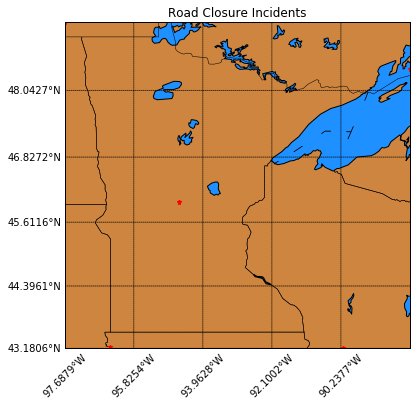

In [439]:
plt.figure(figsize=(12,6))
# Define the projection, scale, the corners of the map, and the resolution.
m = Basemap(projection='merc',llcrnrlat=bbox[0],urcrnrlat=bbox[1],llcrnrlon=bbox[2],urcrnrlon=bbox[3],lat_ts=10,resolution='i')

# Draw coastlines and fill continents and water with color
m.drawcoastlines()
m.fillcontinents(color='peru',lake_color='dodgerblue')

# draw parallels, meridians, and color boundaries
m.drawparallels(np.arange(bbox[0],bbox[1],(bbox[1]-bbox[0])/5),labels=[1,0,0,0])
m.drawmeridians(np.arange(bbox[2],bbox[3],(bbox[3]-bbox[2])/5),labels=[0,0,0,1],rotation=45)
m.drawmapboundary(fill_color='dodgerblue')

#https://python-graph-gallery.com/286-boundaries-provided-in-basemap/
m.drawstates()
m.drawcountries()


# build and plot coordinates onto map
x,y = m(lons,lats)
m.plot(x,y,'r*',markersize=5)
plt.title("Road Closure Incidents")
#plt.savefig('asos_station_plot.png', format='png', dpi=500)
plt.show()